# Exploring Sentence-Transformer Loss Functions on Simulated Multi‑Omics Captions
This notebook simulates several captioning datasets for a multi‑omics setting and trains a custom `MMContextEncoder` using a range of loss functions from **Sentence‑Transformers**.

*Author: auto‑generated on 2025‑05‑15 13:57*

## 1. Setup & imports

In [22]:
import logging
import os
from datetime import datetime
from pathlib import Path

import numpy as np
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from tqdm.autonotebook import tqdm

from mmcontext.mmcontextencoder import MMContextEncoder
from mmcontext.sanity_helpers import cluster_variances, plot_pca, stack_embeddings
from mmcontext.simulator import OmicsCaptionSimulator, make_cluster_sampler

# --------------------------------------------------------------------
# Global logger
# --------------------------------------------------------------------
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## 2. Helper functions

In [23]:
def get_output_dir(base_dir: str, loss_name: str) -> Path:
    """Create a timestamped output directory for a specific loss.

    Parameters
    ----------
    base_dir : str
        Root directory where model checkpoints should be written.
    loss_name : str
        Name of the loss function used for training.

    Returns
    -------
    pathlib.Path
        Path object pointing to the (newly‑created) output directory.
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = Path(base_dir) / f"{loss_name}_{timestamp}"
    out.mkdir(parents=True, exist_ok=True)
    logger.info("Using output directory %s", out)
    return out


def plot_training_loss(trainer):
    """Plot the training loss curve recorded by a `SentenceTransformerTrainer`.

    Parameters
    ----------
    trainer : SentenceTransformerTrainer
        The trainer instance after calling `.train()`.
    """
    import matplotlib.pyplot as plt

    steps, losses_ = [], []
    for h in trainer.state.log_history:
        if "loss" in h and "epoch" in h:
            steps.append(h["step"])
            losses_.append(h["loss"])

    if not steps:
        logger.warning("No loss values found in trainer log history – did you set `logging_steps`?")
        return

    plt.figure()
    plt.plot(steps, losses_, marker="o")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training loss")
    plt.grid(True)
    plt.show()

## 3. Simulate captioning datasets

In [32]:
# Simulation parameters
N_SAMPLES = 600
NOISE = 0.5
rng_seed = 42

logger.info("Simulating %d samples (noise=%.2f)…", N_SAMPLES, NOISE)
sim = OmicsCaptionSimulator(n_samples=N_SAMPLES, numeric_sampler=None).simulate()
cell_types = list(sim.adata.obs["cell_type"])  # ground‑truth labels

# Cluster‑aware sampler for numeric modality
sim.numeric_sampler = make_cluster_sampler(labels=cell_types, noise=NOISE)
sim._build_embeddings()

# Dataframe needed to register the model
gene_df, sample_df = sim.get_dataframes()

# --------------------------------------------------------------------
# Build HuggingFace datasets for the different presets
# --------------------------------------------------------------------
preset_kwargs = {
    "pair": {"comment": "anchor–positive pairs, for MultipleNegatives* losses"},
    "triplet": {"comment": "anchor/positive/negative triplets, for TripletLoss, Batch*TripletLosses"},
    "pair-binary": {"comment": "positive/negative pairs with 0/1 label, for Contrastive losses"},
    "single-class": {"comment": "single sentence with integer class label, for batch‑hard/semi‑hard triplet losses"},
}

hf_datasets = {}
for preset in preset_kwargs:
    sim._build_hf_dataset(preset=preset)
    hf_datasets[preset] = sim.get_hf_dataset()
    logger.info("Built preset '%s' – %s", preset, preset_kwargs[preset]["comment"])

Filter: 100%|██████████| 600/600 [00:00<00:00, 193627.94 examples/s]


## 4. Initialise encoder and derive baseline embeddings

In [33]:
# Instantiate model components
enc = MMContextEncoder(
    text_encoder_name="one_hot",
    adapter_hidden_dim=None,
    adapter_output_dim=128,
    freeze_text_encoder=True,
    train_lookup=False,
)

# Register the initial numeric embeddings (PCA) so that stack_embeddings() can retrieve them later
enc.register_initial_embeddings(sample_df, data_origin="pca")

# Wrap inside SentenceTransformer so we can use ST training utilities
st_model = SentenceTransformer(modules=[enc])

# Baseline (pre‑training) embeddings – we cache these for variance comparison & plotting
old_emb = stack_embeddings(sample_df)
old_labels = sim.adata.obs["cell_type"].tolist()

## 5. Loss configuration

In [34]:
# Mapping preset → applicable loss classes
preset_to_losses = {
    "pair": [
        losses.MultipleNegativesRankingLoss,
        losses.MultipleNegativesSymmetricRankingLoss,
    ],
    "triplet": [
        losses.TripletLoss,
    ],
    "pair-binary": [
        losses.ContrastiveLoss,
        # losses.OnlineContrastiveLoss,
    ],
    "single-class": [
        losses.BatchAllTripletLoss,
        losses.BatchHardSoftMarginTripletLoss,
        losses.BatchHardTripletLoss,
        losses.BatchSemiHardTripletLoss,
    ],
}

# Fixed ST training hyper‑parameters
BASE_OUTDIR = "./models/demo_random"
TRAIN_ARGS = {
    "num_train_epochs": 2,
    "per_device_train_batch_size": 64,
    "per_device_eval_batch_size": 64,
    "learning_rate": 3e-3,
    "logging_steps": 1,
    "report_to": "wandb",  # change/remove as desired
}

## 6. Training loop across losses

 44%|████▍     | 7/16 [00:00<00:00, 46.63it/s]                       

{'loss': 5.1728, 'grad_norm': 5.703880310058594, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 4.4447, 'grad_norm': 5.022186279296875, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 3.8935, 'grad_norm': 4.4479146003723145, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 3.3988, 'grad_norm': 3.9643027782440186, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 3.1505, 'grad_norm': 3.624006509780884, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 2.7907, 'grad_norm': 2.865931510925293, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 2.5472, 'grad_norm': 2.065027952194214, 'learning_rate': 0.0016875, 'epoch': 0.88}


100%|██████████| 16/16 [00:00<00:00, 32.66it/s]

{'loss': 1.8788, 'grad_norm': 2.256648063659668, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 2.2581, 'grad_norm': 1.6289124488830566, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 2.1749, 'grad_norm': 1.3139151334762573, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 2.094, 'grad_norm': 0.9905543327331543, 'learning_rate': 0.0009375, 'epoch': 1.38}
{'loss': 2.1239, 'grad_norm': 0.7707100510597229, 'learning_rate': 0.00075, 'epoch': 1.5}
{'loss': 2.0684, 'grad_norm': 0.6681475639343262, 'learning_rate': 0.0005625000000000001, 'epoch': 1.62}
{'loss': 2.0356, 'grad_norm': 0.6769596338272095, 'learning_rate': 0.000375, 'epoch': 1.75}
{'loss': 2.0613, 'grad_norm': 0.5168942809104919, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 1.3263, 'grad_norm': 0.5375216603279114, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 10.98it/s]

{'train_runtime': 1.4645, 'train_samples_per_second': 655.534, 'train_steps_per_second': 10.926, 'train_loss': 2.7137288078665733, 'epoch': 2.0}


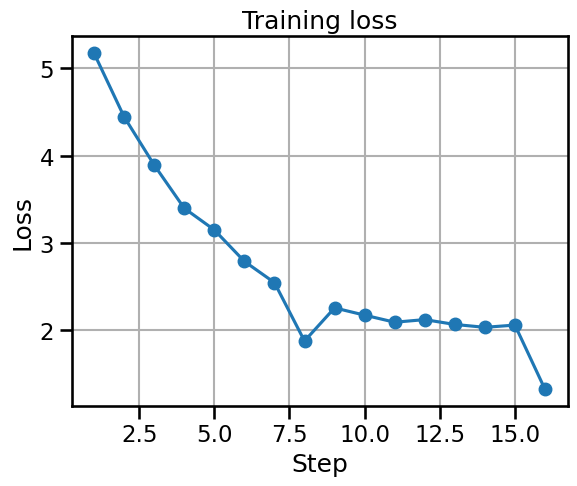

100%|██████████| 16/16 [00:00<00:00, 69.93it/s]                      

{'loss': 2.0568, 'grad_norm': 0.5188410878181458, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 1.9956, 'grad_norm': 0.3711297810077667, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 2.0669, 'grad_norm': 0.3326404392719269, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 2.0036, 'grad_norm': 0.2241533100605011, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 1.972, 'grad_norm': 0.2587980031967163, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 1.9859, 'grad_norm': 0.2371285855770111, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 2.0181, 'grad_norm': 0.207346573472023, 'learning_rate': 0.0016875, 'epoch': 0.88}
{'loss': 1.4359, 'grad_norm': 0.2722819745540619, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 1.9427, 'grad_norm': 0.2028196007013321, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 1.9293, 'grad_norm': 0.18002431094646454, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 1.9311, 'grad_norm': 0.17561452090740204, 'le

100%|██████████| 16/16 [00:01<00:00, 11.52it/s]

{'train_runtime': 1.3937, 'train_samples_per_second': 688.813, 'train_steps_per_second': 11.48, 'train_loss': 1.9063937291502953, 'epoch': 2.0}


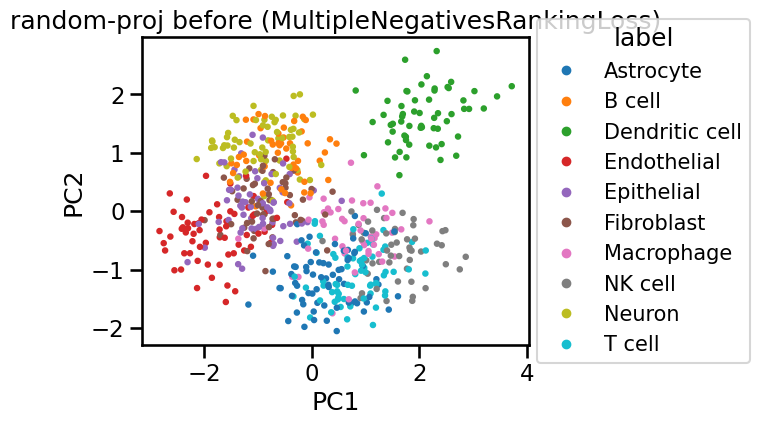

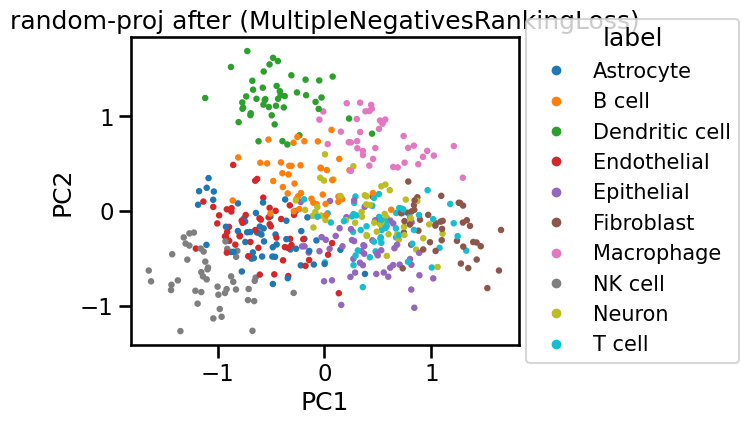

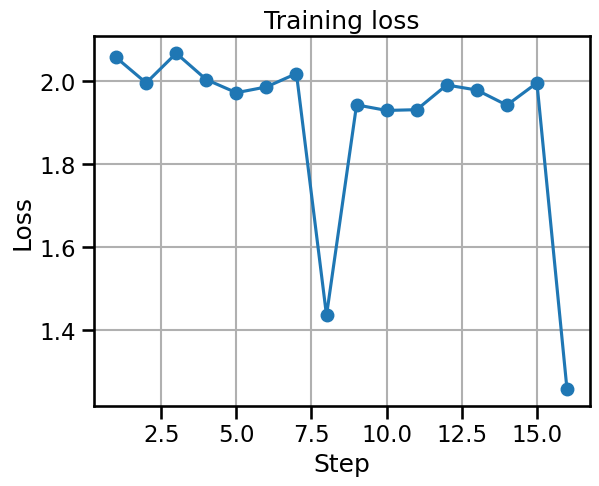

 50%|█████     | 8/16 [00:00<00:00, 48.31it/s]                       

{'loss': 5.3419, 'grad_norm': 3.155601739883423, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 5.1779, 'grad_norm': 2.861863851547241, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 4.4698, 'grad_norm': 2.99466872215271, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 4.3242, 'grad_norm': 2.946220636367798, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 3.6984, 'grad_norm': 2.8586392402648926, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 4.2055, 'grad_norm': 2.6291146278381348, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 4.246, 'grad_norm': 2.4814276695251465, 'learning_rate': 0.0016875, 'epoch': 0.88}
{'loss': 3.4905, 'grad_norm': 3.121081590652466, 'learning_rate': 0.0015, 'epoch': 1.0}


100%|██████████| 16/16 [00:00<00:00, 45.22it/s]

{'loss': 3.5758, 'grad_norm': 2.7525556087493896, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 3.1028, 'grad_norm': 2.4297027587890625, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 3.2659, 'grad_norm': 2.4822065830230713, 'learning_rate': 0.0009375, 'epoch': 1.38}
{'loss': 2.7386, 'grad_norm': 2.333092212677002, 'learning_rate': 0.00075, 'epoch': 1.5}
{'loss': 2.4438, 'grad_norm': 2.4972083568573, 'learning_rate': 0.0005625000000000001, 'epoch': 1.62}
{'loss': 2.549, 'grad_norm': 2.4650590419769287, 'learning_rate': 0.000375, 'epoch': 1.75}
{'loss': 2.2436, 'grad_norm': 2.01705002784729, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 2.5637, 'grad_norm': 2.392746925354004, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 11.17it/s]

{'train_runtime': 1.4378, 'train_samples_per_second': 667.666, 'train_steps_per_second': 11.128, 'train_loss': 3.589833453297615, 'epoch': 2.0}


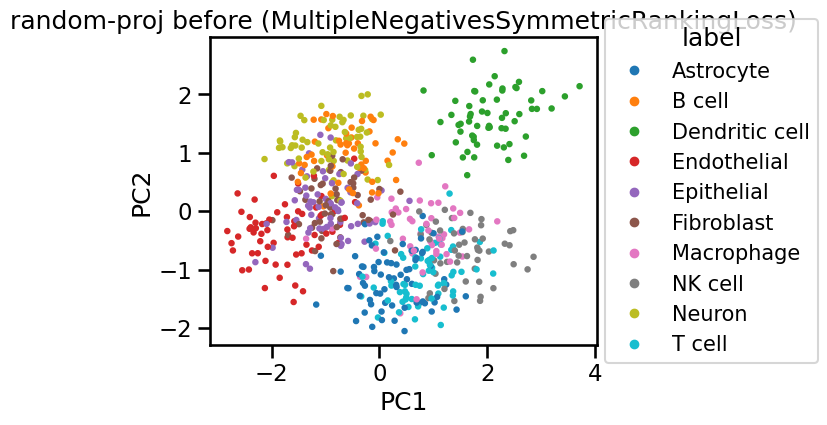

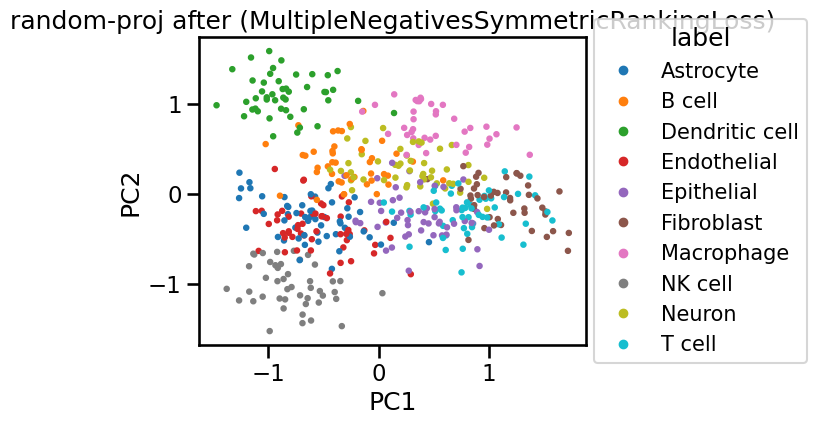

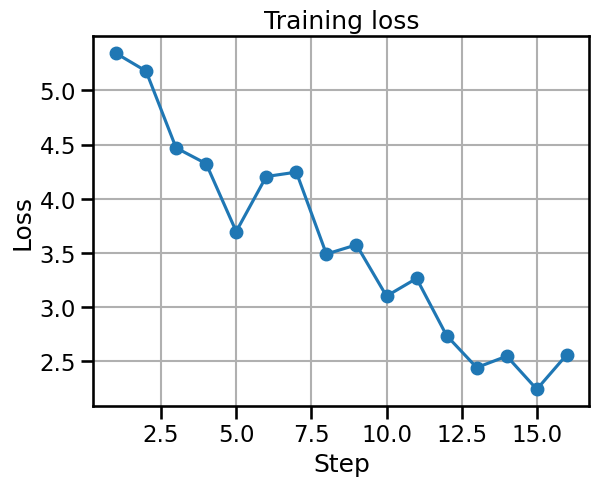

 53%|█████▎    | 16/30 [00:00<00:00, 73.52it/s]                      

{'loss': 0.0697, 'grad_norm': 0.04846261069178581, 'learning_rate': 0.0029000000000000002, 'epoch': 0.07}
{'loss': 0.0422, 'grad_norm': 0.033581484109163284, 'learning_rate': 0.0028, 'epoch': 0.13}
{'loss': 0.0543, 'grad_norm': 0.03978269174695015, 'learning_rate': 0.0027, 'epoch': 0.2}
{'loss': 0.045, 'grad_norm': 0.03340254724025726, 'learning_rate': 0.0026000000000000003, 'epoch': 0.27}
{'loss': 0.0463, 'grad_norm': 0.0346510224044323, 'learning_rate': 0.0025, 'epoch': 0.33}
{'loss': 0.0474, 'grad_norm': 0.03832997754216194, 'learning_rate': 0.0024000000000000002, 'epoch': 0.4}
{'loss': 0.042, 'grad_norm': 0.03608608618378639, 'learning_rate': 0.0023000000000000004, 'epoch': 0.47}
{'loss': 0.0262, 'grad_norm': 0.025997580960392952, 'learning_rate': 0.0021999999999999997, 'epoch': 0.53}
{'loss': 0.0428, 'grad_norm': 0.03339289128780365, 'learning_rate': 0.0021, 'epoch': 0.6}
{'loss': 0.0383, 'grad_norm': 0.030308356508612633, 'learning_rate': 0.002, 'epoch': 0.67}
{'loss': 0.0375, 'g

100%|██████████| 30/30 [00:00<00:00, 72.18it/s]

{'loss': 0.0248, 'grad_norm': 0.021476930007338524, 'learning_rate': 0.0014, 'epoch': 1.07}
{'loss': 0.0263, 'grad_norm': 0.024285444989800453, 'learning_rate': 0.0013000000000000002, 'epoch': 1.13}
{'loss': 0.0268, 'grad_norm': 0.0205200407654047, 'learning_rate': 0.0012000000000000001, 'epoch': 1.2}
{'loss': 0.0249, 'grad_norm': 0.019857322797179222, 'learning_rate': 0.0010999999999999998, 'epoch': 1.27}
{'loss': 0.0243, 'grad_norm': 0.02163754589855671, 'learning_rate': 0.001, 'epoch': 1.33}
{'loss': 0.0207, 'grad_norm': 0.016122717410326004, 'learning_rate': 0.0009, 'epoch': 1.4}
{'loss': 0.0185, 'grad_norm': 0.019910577684640884, 'learning_rate': 0.0008, 'epoch': 1.47}
{'loss': 0.0216, 'grad_norm': 0.018176617100834846, 'learning_rate': 0.0007, 'epoch': 1.53}
{'loss': 0.0197, 'grad_norm': 0.018151380121707916, 'learning_rate': 0.0006000000000000001, 'epoch': 1.6}
{'loss': 0.0191, 'grad_norm': 0.016349831596016884, 'learning_rate': 0.0005, 'epoch': 1.67}
{'loss': 0.0217, 'grad_norm

100%|██████████| 30/30 [00:01<00:00, 18.96it/s]

{'train_runtime': 1.5855, 'train_samples_per_second': 1210.946, 'train_steps_per_second': 18.921, 'train_loss': 0.03166759933034579, 'epoch': 2.0}


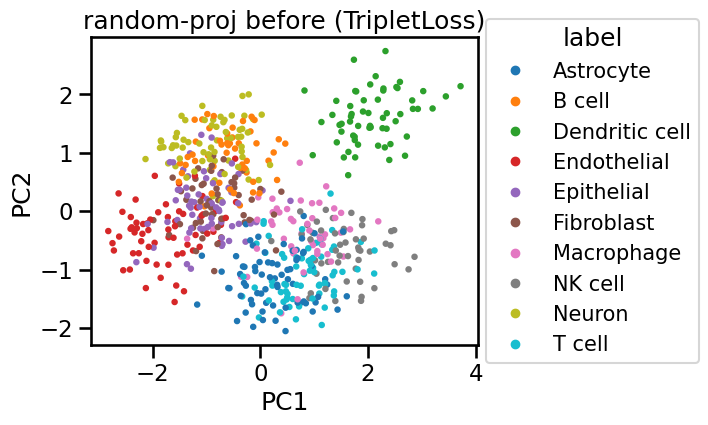

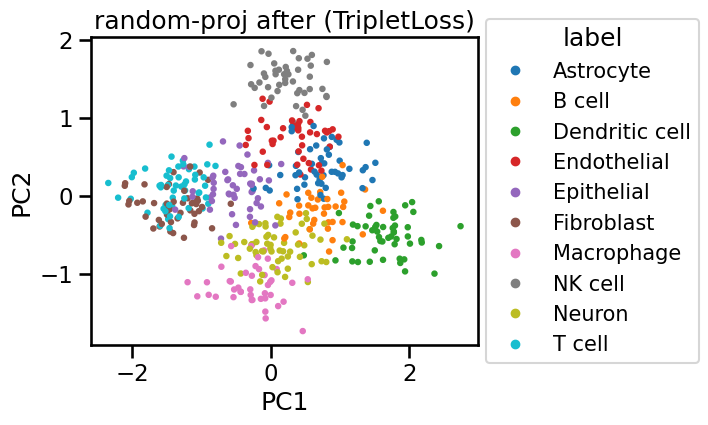

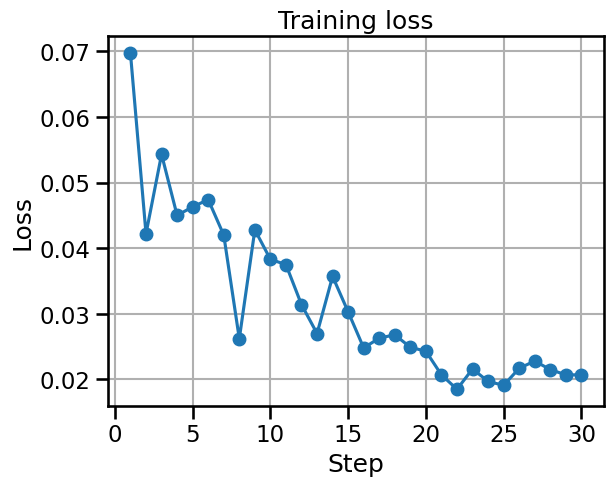

 56%|█████▋    | 9/16 [00:00<00:00, 61.74it/s]                       

{'loss': 0.5014, 'grad_norm': 3.3422718048095703, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 0.6755, 'grad_norm': 3.134509801864624, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 0.8391, 'grad_norm': 3.0421955585479736, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 0.3265, 'grad_norm': 3.425260066986084, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 0.5049, 'grad_norm': 2.885338544845581, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 0.5324, 'grad_norm': 3.52907133102417, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 0.9224, 'grad_norm': 4.011778354644775, 'learning_rate': 0.0016875, 'epoch': 0.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 0.5011, 'grad_norm': 3.933107614517212, 'learning_rate': 0.0013125, 'epoch': 1.12}


100%|██████████| 16/16 [00:00<00:00, 46.06it/s]

{'loss': 0.3695, 'grad_norm': 4.765552997589111, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 0.6338, 'grad_norm': 3.4928574562072754, 'learning_rate': 0.0009375, 'epoch': 1.38}
{'loss': 0.22, 'grad_norm': 4.990573406219482, 'learning_rate': 0.00075, 'epoch': 1.5}
{'loss': 0.7774, 'grad_norm': 3.3597700595855713, 'learning_rate': 0.0005625000000000001, 'epoch': 1.62}
{'loss': 0.4756, 'grad_norm': 4.717731475830078, 'learning_rate': 0.000375, 'epoch': 1.75}
{'loss': 0.3691, 'grad_norm': 5.760953426361084, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 11.27it/s]

{'train_runtime': 1.424, 'train_samples_per_second': 674.168, 'train_steps_per_second': 11.236, 'train_loss': 0.4780406132340431, 'epoch': 2.0}


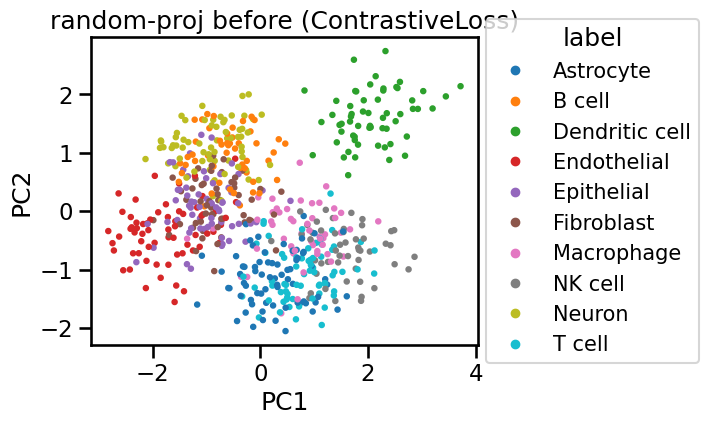

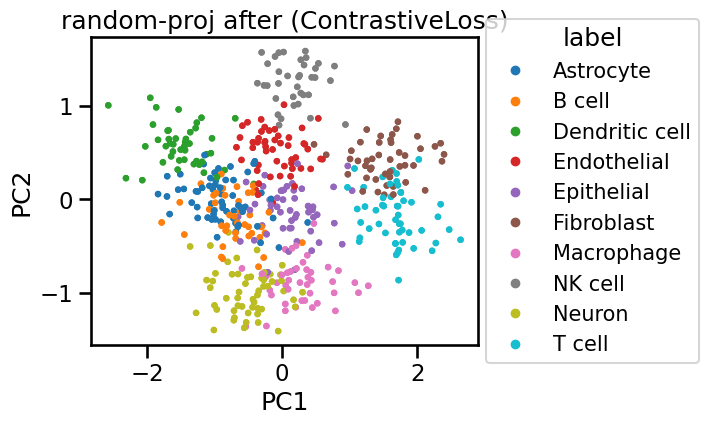

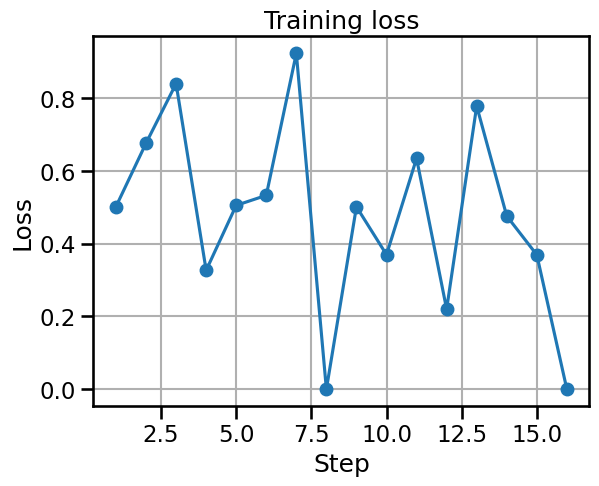

 75%|███████▌  | 12/16 [00:00<00:00, 44.30it/s]                      

{'loss': 0.0015, 'grad_norm': 0.0036671513225883245, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 0.0022, 'grad_norm': 0.005979836918413639, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 0.0041, 'grad_norm': 0.01427321694791317, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 0.0016, 'grad_norm': 0.004343738313764334, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 0.002, 'grad_norm': 0.005214578006416559, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 0.0019, 'grad_norm': 0.005124793853610754, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 0.0078, 'grad_norm': 0.03239268809556961, 'learning_rate': 0.0016875, 'epoch': 0.88}
{'loss': 0.0005, 'grad_norm': 0.0015243468806147575, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 0.0016, 'grad_norm': 0.005060294643044472, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 0.0012, 'grad_norm': 0.003959314431995153, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 0.003, 'grad_norm': 0.011

100%|██████████| 16/16 [00:00<00:00, 44.30it/s]

{'loss': 0.003, 'grad_norm': 0.009389761835336685, 'learning_rate': 0.0005625000000000001, 'epoch': 1.62}
{'loss': 0.0018, 'grad_norm': 0.0068841008469462395, 'learning_rate': 0.000375, 'epoch': 1.75}
{'loss': 0.0013, 'grad_norm': 0.005827269051223993, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 0.0003, 'grad_norm': 0.001264355261810124, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 11.84it/s]

{'train_runtime': 1.3599, 'train_samples_per_second': 705.96, 'train_steps_per_second': 11.766, 'train_loss': 0.0021495046767086023, 'epoch': 2.0}


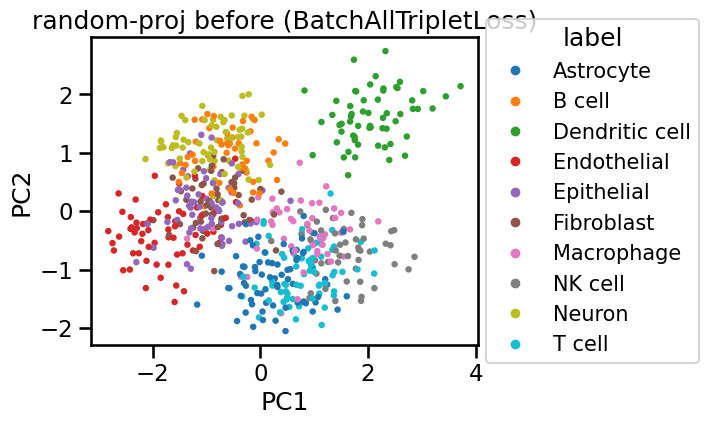

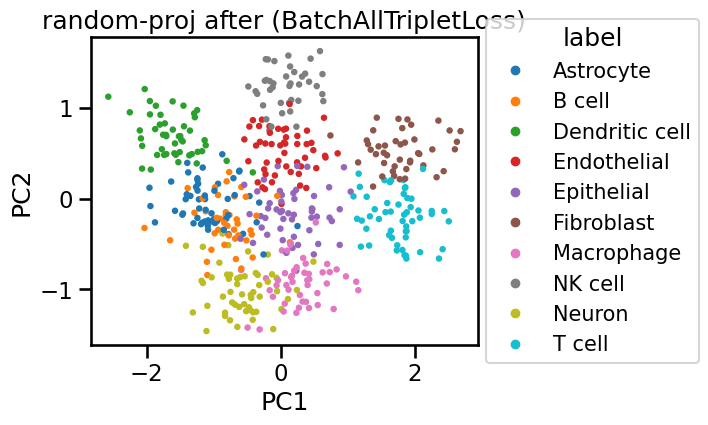

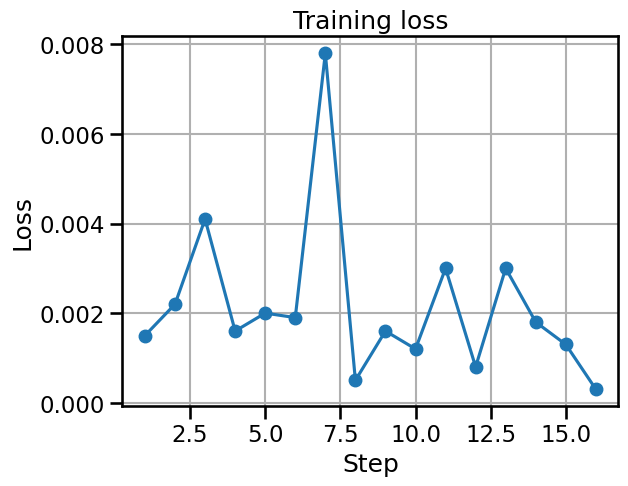

Batches: 100%|██████████| 2/2 [00:00<00:00, 168.28it/s]
                                                                     

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 0.0057, 'grad_norm': 0.1439392864704132, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 0.0275, 'grad_norm': 0.17482136189937592, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 0.007, 'grad_norm': 0.1371850222349167, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 0.0146, 'grad_norm': 0.1915610432624817, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 0.0149, 'grad_norm': 0.2198541760444641, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 0.1265, 'grad_norm': 0.5285135507583618, 'learning_rate': 0.0016875, 'epoch': 0.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 0.0133, 'grad_norm': 0.17927150428295135, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 0.0031, 'grad_norm': 0.11986514925956726, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 0.0662, 'grad_norm': 0.27126094698905945, 'learning_rate': 0.0009375, 'epoch':

100%|██████████| 16/16 [00:00<00:00, 66.38it/s]

{'loss': 0.0345, 'grad_norm': 0.23174549639225006, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 12.03it/s]

{'train_runtime': 1.3397, 'train_samples_per_second': 716.565, 'train_steps_per_second': 11.943, 'train_loss': 0.023647930473089218, 'epoch': 2.0}


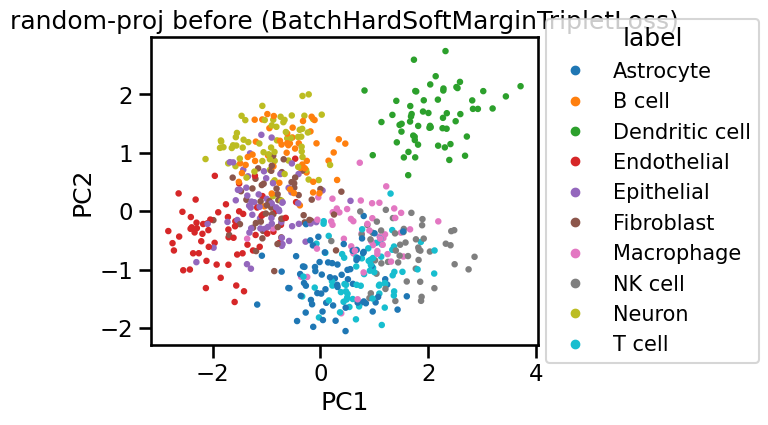

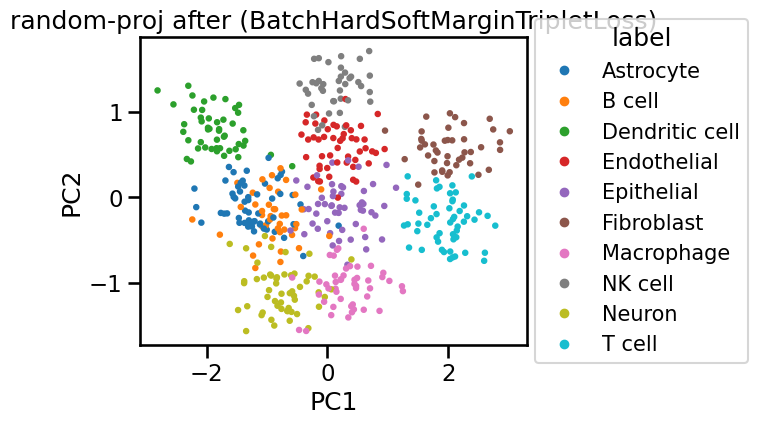

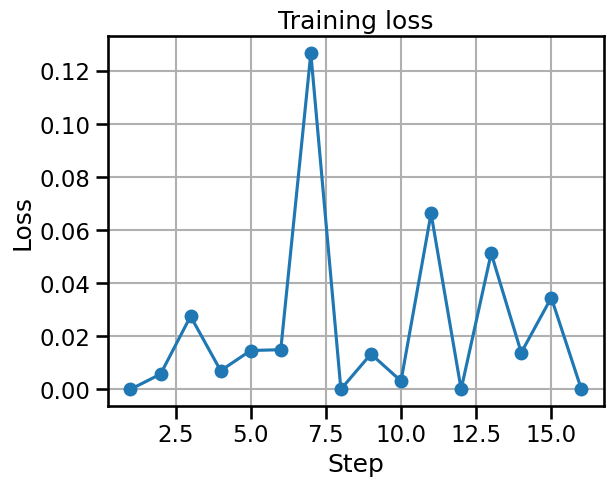

 44%|████▍     | 7/16 [00:00<00:00, 69.82it/s]                       

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0028125, 'epoch': 0.12}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.002625, 'epoch': 0.25}
{'loss': 0.0001, 'grad_norm': 0.01572655700147152, 'learning_rate': 0.0024375, 'epoch': 0.38}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0022500000000000003, 'epoch': 0.5}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0020625, 'epoch': 0.62}
{'loss': 0.0006, 'grad_norm': 0.014645393937826157, 'learning_rate': 0.001875, 'epoch': 0.75}
{'loss': 0.0196, 'grad_norm': 0.1500801295042038, 'learning_rate': 0.0016875, 'epoch': 0.88}


100%|██████████| 16/16 [00:00<00:00, 33.84it/s]

{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0015, 'epoch': 1.0}
{'loss': 0.0019, 'grad_norm': 0.026063427329063416, 'learning_rate': 0.0013125, 'epoch': 1.12}
{'loss': 0.0002, 'grad_norm': 0.017602209001779556, 'learning_rate': 0.0011250000000000001, 'epoch': 1.25}
{'loss': 0.0112, 'grad_norm': 0.060663461685180664, 'learning_rate': 0.0009375, 'epoch': 1.38}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.00075, 'epoch': 1.5}
{'loss': 0.0079, 'grad_norm': 0.08766724914312363, 'learning_rate': 0.0005625000000000001, 'epoch': 1.62}
{'loss': 0.0008, 'grad_norm': 0.017019137740135193, 'learning_rate': 0.000375, 'epoch': 1.75}
{'loss': 0.008, 'grad_norm': 0.05867597088217735, 'learning_rate': 0.0001875, 'epoch': 1.88}
{'loss': 0.0, 'grad_norm': 0.0, 'learning_rate': 0.0, 'epoch': 2.0}


100%|██████████| 16/16 [00:01<00:00, 11.35it/s]

{'train_runtime': 1.4173, 'train_samples_per_second': 677.364, 'train_steps_per_second': 11.289, 'train_loss': 0.00314307489861676, 'epoch': 2.0}


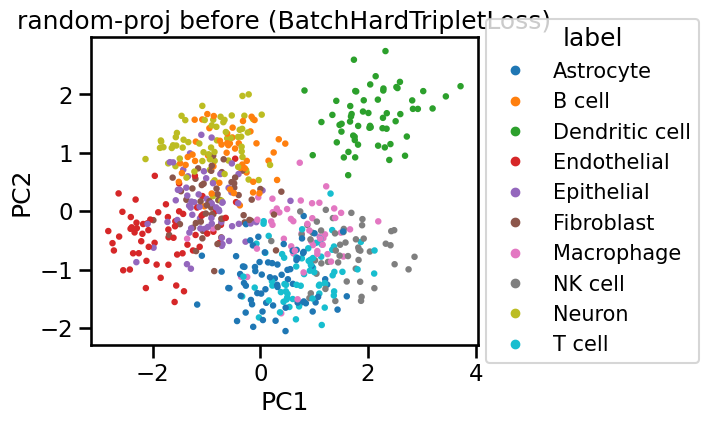

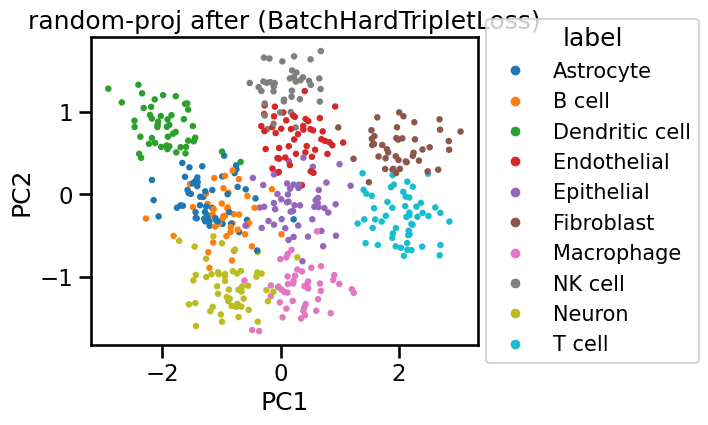

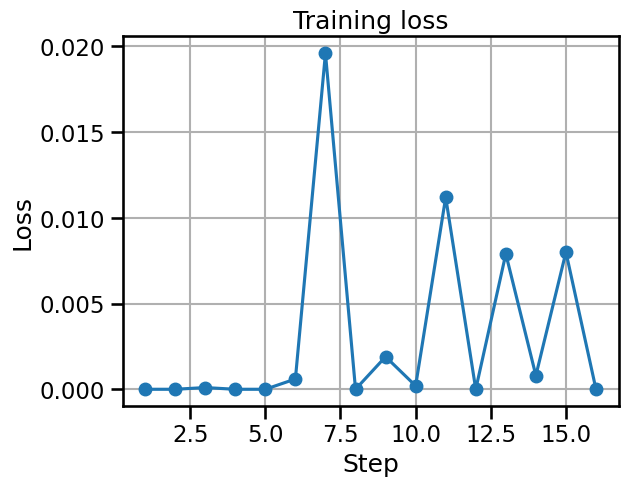

Batches: 100%|██████████| 2/2 [00:00<00:00, 174.23it/s]


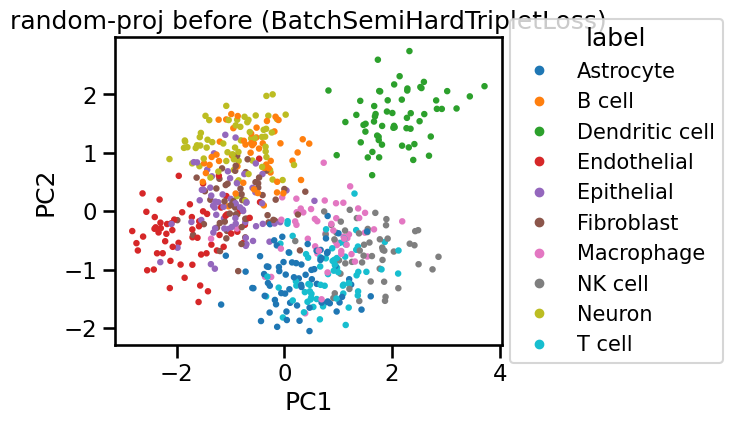

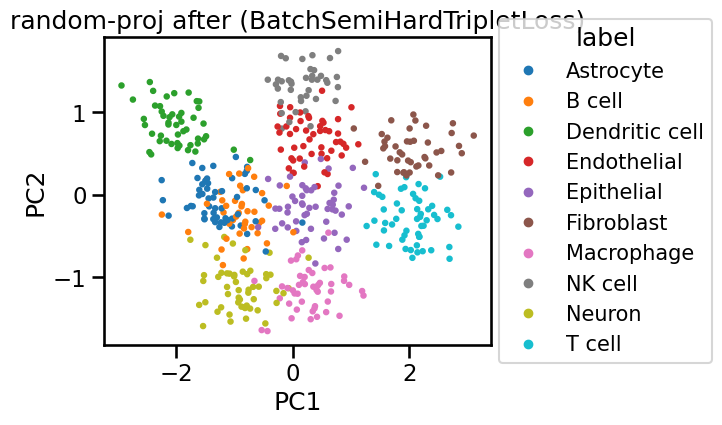

In [35]:
results = []  # keep metrics for later comparison

for preset, loss_classes in preset_to_losses.items():
    logger.info("\n=== Preset %s ===", preset)
    ds_dict = hf_datasets[preset]
    train_ds, val_ds = ds_dict["train"], ds_dict["validation"]

    # Track sample indices (if present) so we can recover cell‑type labels later
    if "sample_idx" in train_ds.column_names:
        train_sample_idx = train_ds["sample_idx"]
        train_ds_noidx = train_ds.remove_columns(["sample_idx"])
    else:
        train_sample_idx = None
        train_ds_noidx = train_ds

    for loss_cls in loss_classes:
        loss_name = loss_cls.__name__
        logger.info("‑‑ Training with %s", loss_name)

        # Create loss instance **on a NEW SentenceTransformer copy** so weights reset each run
        model_copy = SentenceTransformer(modules=[enc])  # fresh wrapper but reuses same MMContextEncoder weights
        loss_fn = loss_cls(model_copy)

        out_dir = get_output_dir(BASE_OUTDIR, loss_name)
        run_name = f"sim_{loss_name.lower()}"

        args = SentenceTransformerTrainingArguments(output_dir=str(out_dir), run_name=run_name, **TRAIN_ARGS)
        trainer = SentenceTransformerTrainer(
            model=model_copy,
            args=args,
            train_dataset=train_ds_noidx,
            loss=loss_fn,
        )

        trainer.train()
        plot_training_loss(trainer)

        # ------------------------------------------------------------------
        #   Inference on training anchors ("sentence1" or equivalent)
        # ------------------------------------------------------------------
        if "anchor" in train_ds.column_names:
            primary_sentences = train_ds["anchor"]
        elif "sentence1" in train_ds.column_names:
            primary_sentences = train_ds["sentence1"]
        elif "sentence" in train_ds.column_names:
            primary_sentences = train_ds["sentence"]
        else:
            raise ValueError(f"Cannot determine primary sentence column for preset {preset}")

        new_emb = model_copy.encode(primary_sentences, batch_size=256, convert_to_numpy=True, show_progress_bar=True)

        # Determine labels for variance calculation
        if train_sample_idx is not None:
            new_labels = sim.adata.obs["cell_type"][train_sample_idx]
        elif "label" in train_ds.column_names and train_ds.features["label"].int2str is not None:
            new_labels = train_ds.features["label"].int2str(train_ds["label"])
        else:
            new_labels = ["unknown"] * len(primary_sentences)

        within0, between0 = cluster_variances(old_emb, old_labels)
        within1, between1, sil1 = cluster_variances(new_emb, new_labels, return_silhouette=True)

        logger.info("initial  : within=%.4f   between=%.4f", within0, between0)
        logger.info("trained  : within=%.4f   between=%.4f   sil=%.3f", within1, between1, sil1)

        # Random 2‑D projection for visual intuition
        rng = np.random.default_rng(42)
        k = 2
        R_old = rng.standard_normal((old_emb.shape[1], k))
        R_old /= np.linalg.norm(R_old, axis=0, keepdims=True)
        R_new = rng.standard_normal((new_emb.shape[1], k))
        R_new /= np.linalg.norm(R_new, axis=0, keepdims=True)

        old_2d = old_emb @ R_old
        new_2d = new_emb @ R_new

        plot_pca(old_2d, old_labels, title=f"random‑proj before ({loss_name})", point_size=10, legend_out=True)
        plot_pca(new_2d, new_labels, title=f"random‑proj after ({loss_name})", point_size=10, legend_out=True)

        results.append(
            {
                "preset": preset,
                "loss": loss_name,
                "within_pre": within0,
                "between_pre": between0,
                "within_post": within1,
                "between_post": between1,
                "silhouette_post": sil1,
                "output_dir": str(out_dir),
            }
        )

## 7. Summary table

In [31]:
import pandas as pd

pd.DataFrame(results)

,preset,loss,within_pre,between_pre,within_post,between_post,silhouette_post,output_dir
0,pair,MultipleNegativesRankingLoss,0.250626,0.966933,0.548353,5.947008,0.910700,models/demo_random/MultipleNegativesRankingLos...
1,pair,MultipleNegativesSymmetricRankingLoss,0.250626,0.966933,0.549970,5.784824,0.907440,models/demo_random/MultipleNegativesSymmetricR...
2,triplet,TripletLoss,0.250626,0.966933,0.379961,2.680278,0.863807,models/demo_random/TripletLoss_20250515_161505
3,pair-binary,ContrastiveLoss,0.250626,0.966933,0.377875,3.051233,0.882517,models/demo_random/ContrastiveLoss_20250515_16...
4,single-class,BatchAllTripletLoss,0.250626,0.966933,0.389249,3.383857,0.890530,models/demo_random/BatchAllTripletLoss_2025051...
5,single-class,BatchHardSoftMarginTripletLoss,0.250626,0.966933,0.443060,4.464258,0.902933,models/demo_random/BatchHardSoftMarginTripletL...
6,single-class,BatchHardTripletLoss,0.250626,0.966933,0.443302,4.470211,0.902955,models/demo_random/BatchHardTripletLoss_202505...
7,single-class,BatchSemiHardTripletLoss,0.250626,0.966933,0.443473,4.475437,0.902976,models/demo_random/BatchSemiHardTripletLoss_20...
